# **Task 3: Training Variational Autoencoders**

# **Part 1: Training variational Autoencoder**

In [1]:
# a) download th FahsionMNIST dataset from  torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# download FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\nFashionMNIST Dataset loaded")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

# fashionMNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Using device: cpu


100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.87MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 51.0MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.54MB/s]



FashionMNIST Dataset loaded
Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


In [2]:
# b) donwload architecture.py  from VAE architecture

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        # latent space
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()  # Output in [0, 1]
        )

        self.latent_dim = latent_dim

    def encode(self, x):

        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # flatten input
        x = x.view(-1, 28*28)

        # encode
        mu, logvar = self.encode(x)

        # sample latent vector
        z = self.reparameterize(mu, logvar)

        # decode
        reconstruction = self.decode(z)

        return reconstruction, mu, logvar


# initialize model
latent_dim = 20
model = VAE(latent_dim=latent_dim).to(device)

print(f"\nVAE Model initialized")
print(f"Latent dimension: {latent_dim}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


VAE Model initialized
Latent dimension: 20
Total parameters: 1,082,680


In [3]:
# c) define the loss function (MSE+ KL divergence) and train the model

def vae_loss(reconstruction, x, mu, logvar):

    # flatten inputs
    x = x.view(-1, 28*28)

    # reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(reconstruction, x, reduction='sum')

    # kL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # total loss
    total_loss = recon_loss + kld_loss

    return total_loss, recon_loss, kld_loss


def train_vae(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kld_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()

        # forward pass
        reconstruction, mu, logvar = model(data)

        # compute loss
        loss, recon_loss, kld_loss = vae_loss(reconstruction, data, mu, logvar)

        # backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kld_loss += kld_loss.item()

    # average losses
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = train_recon_loss / len(train_loader.dataset)
    avg_kld = train_kld_loss / len(train_loader.dataset)

    return avg_loss, avg_recon, avg_kld


def validate_vae(model, test_loader):
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    val_kld_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)

            # forward pass
            reconstruction, mu, logvar = model(data)

            # compute loss
            loss, recon_loss, kld_loss = vae_loss(reconstruction, data, mu, logvar)

            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_kld_loss += kld_loss.item()

    # average losses
    avg_loss = val_loss / len(test_loader.dataset)
    avg_recon = val_recon_loss / len(test_loader.dataset)
    avg_kld = val_kld_loss / len(test_loader.dataset)

    return avg_loss, avg_recon, avg_kld


# training setup
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

print("\n" + "="*70)
print("TRAINING VAE")
print("="*70)


TRAINING VAE


Epoch 1/20
  Train - Loss: 39.1922 | Recon: 33.8454 | KLD: 5.3468
  Val   - Loss: 28.6449 | Recon: 22.5109 | KLD: 6.1340
Epoch 2/20
  Train - Loss: 27.1788 | Recon: 20.7804 | KLD: 6.3984
  Val   - Loss: 26.6447 | Recon: 20.0780 | KLD: 6.5667
Epoch 3/20
  Train - Loss: 25.9647 | Recon: 19.3194 | KLD: 6.6453
  Val   - Loss: 25.6714 | Recon: 19.0274 | KLD: 6.6440
Epoch 4/20
  Train - Loss: 25.4010 | Recon: 18.6067 | KLD: 6.7943
  Val   - Loss: 25.2349 | Recon: 18.6058 | KLD: 6.6291
Epoch 5/20
  Train - Loss: 25.0178 | Recon: 18.1483 | KLD: 6.8696
  Val   - Loss: 25.0638 | Recon: 17.9271 | KLD: 7.1367
Epoch 6/20
  Train - Loss: 24.7192 | Recon: 17.7279 | KLD: 6.9913
  Val   - Loss: 24.7680 | Recon: 17.9497 | KLD: 6.8183
Epoch 7/20
  Train - Loss: 24.4374 | Recon: 17.3424 | KLD: 7.0950
  Val   - Loss: 24.3695 | Recon: 17.1048 | KLD: 7.2647
Epoch 8/20
  Train - Loss: 24.2882 | Recon: 17.1279 | KLD: 7.1603
  Val   - Loss: 24.2195 | Recon: 17.0297 | KLD: 7.1898
Epoch 9/20
  Train - Loss: 24.12

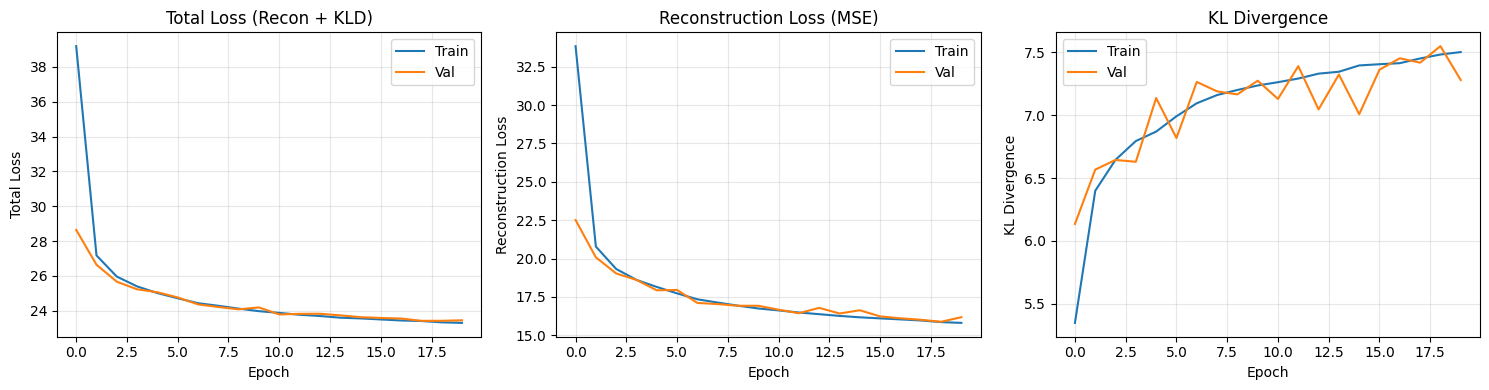


TRAINING COMPLETED


In [4]:
# d) record training and validation losses

# record training and validation losses
history = {
    'train_loss': [], 'train_recon': [], 'train_kld': [],
    'val_loss': [], 'val_recon': [], 'val_kld': []
}

# training loop
for epoch in range(num_epochs):
    # train
    train_loss, train_recon, train_kld = train_vae(model, train_loader, optimizer, epoch)

    # validate
    val_loss, val_recon, val_kld = validate_vae(model, test_loader)

    # record
    history['train_loss'].append(train_loss)
    history['train_recon'].append(train_recon)
    history['train_kld'].append(train_kld)
    history['val_loss'].append(val_loss)
    history['val_recon'].append(val_recon)
    history['val_kld'].append(val_kld)

    # print progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train - Loss: {train_loss:.4f} | Recon: {train_recon:.4f} | KLD: {train_kld:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f} | Recon: {val_recon:.4f} | KLD: {val_kld:.4f}")

# save model
torch.save(model.state_dict(), 'vae_fashionmnist.pth')
print("\nModel saved as 'vae_fashionmnist.pth'")

# plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# total loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Total Loss (Recon + KLD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# reconstruction loss
axes[1].plot(history['train_recon'], label='Train')
axes[1].plot(history['val_recon'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss (MSE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# kL divergence
axes[2].plot(history['train_kld'], label='Train')
axes[2].plot(history['val_kld'], label='Val')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('KL Divergence')
axes[2].set_title('KL Divergence')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vae_training_curves.png', dpi=300)
print("Training curves saved as 'vae_training_curves.png'")
plt.show()

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)

# **Part 2: Visualize Reconstructions and Generations**

Saved: vae_reconstructions.png


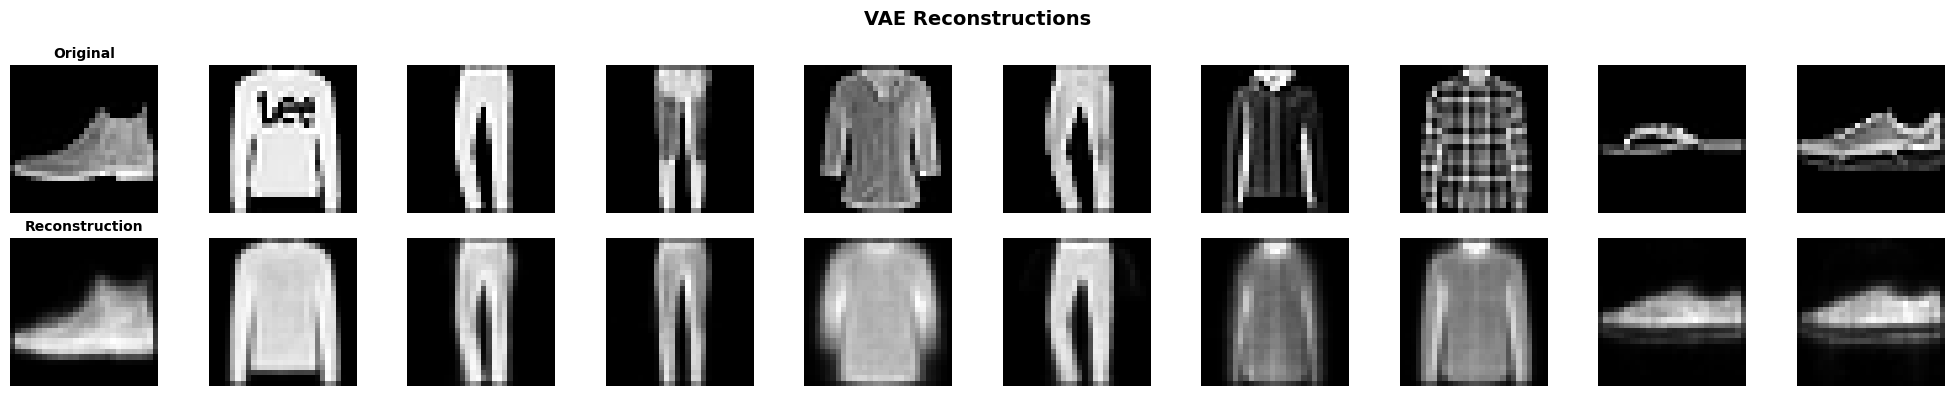

In [5]:
# a) viuslize reconstructions from the encoderdecoder pipeline

import matplotlib.pyplot as plt
import torch

def visualize_reconstructions(model, test_loader, n_samples=10):
    model.eval()

    # get a batch of test images
    data, _ = next(iter(test_loader))
    data = data[:n_samples].to(device)

    with torch.no_grad():
        # get reconstructions
        reconstruction, mu, logvar = model(data)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

    # plot
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples*2, 4))

    for i in range(n_samples):
        # original images
        axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10, fontweight='bold')

        # reconstructions
        axes[1, i].imshow(reconstruction[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstruction', fontsize=10, fontweight='bold')

    plt.suptitle('VAE Reconstructions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('vae_reconstructions.png', dpi=300, bbox_inches='tight')
    print("Saved: vae_reconstructions.png")
    plt.show()


# visualize reconstructions
visualize_reconstructions(model, test_loader, n_samples=10)

Saved: vae_generations.png


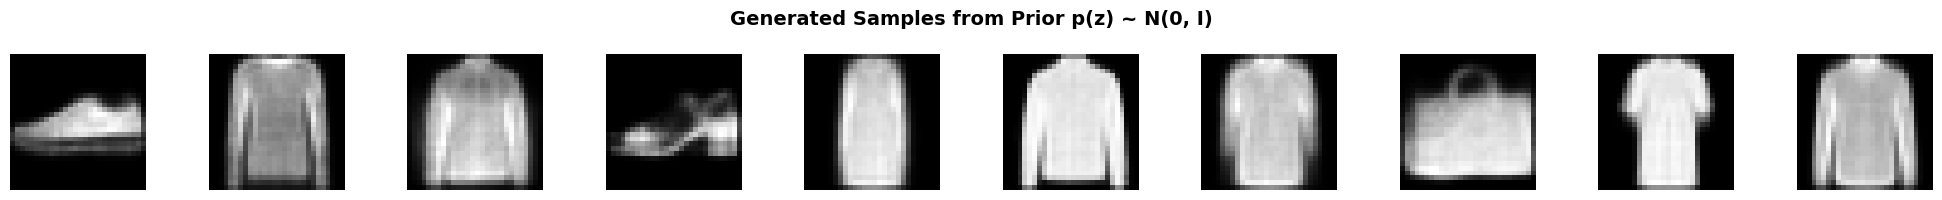

In [6]:
# b) visulise generations by samplying z ~p(z) and decoding

def generate_samples(model, n_samples=10, latent_dim=20):
    model.eval()

    with torch.no_grad():
        # sample from standard normal distribution p(z) = N(0, I)
        z = torch.randn(n_samples, latent_dim).to(device)

        # decode to generate images
        generated = model.decode(z)
        generated = generated.view(-1, 1, 28, 28)

    return generated


def visualize_generations(model, n_samples=10, latent_dim=20):
    # generate samples
    generated = generate_samples(model, n_samples, latent_dim)

    # plot
    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*2, 2))

    for i in range(n_samples):
        axes[i].imshow(generated[i].cpu().squeeze(), cmap='gray')
        axes[i].axis('off')

    plt.suptitle('Generated Samples from Prior p(z) ~ N(0, I)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('vae_generations.png', dpi=300, bbox_inches='tight')
    print("Saved: vae_generations.png")
    plt.show()


# visualize generations
visualize_generations(model, n_samples=10, latent_dim=latent_dim)

Saved: vae_prior_comparison.png


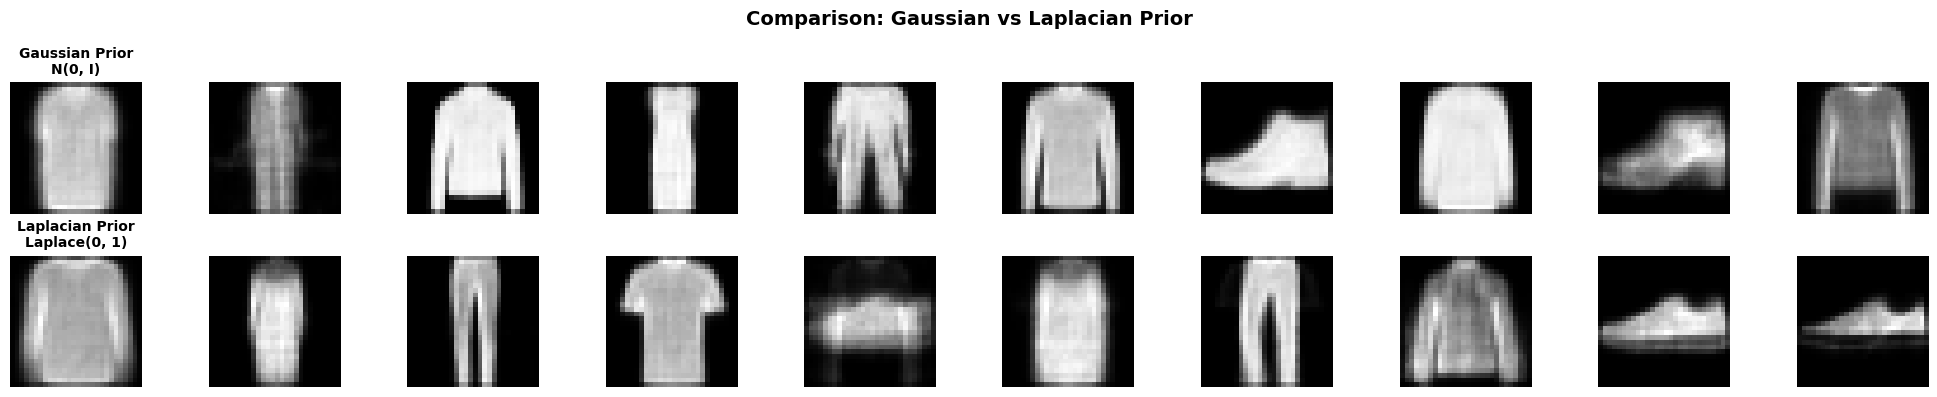

In [7]:
# c) generate samples from different prior distribution (laplace)
import numpy as np

def generate_samples_laplacian(model, n_samples=10, latent_dim=20):
    model.eval()

    with torch.no_grad():
        # sample from Laplacian distribution
        # laplace(0, 1) using numpy then convert to torch
        z_np = np.random.laplace(loc=0.0, scale=1.0, size=(n_samples, latent_dim))
        z = torch.from_numpy(z_np).float().to(device)

        # decode to generate images
        generated = model.decode(z)
        generated = generated.view(-1, 1, 28, 28)

    return generated


def compare_priors(model, n_samples=10, latent_dim=20):
    # generate from Gaussian prior (standard)
    generated_gaussian = generate_samples(model, n_samples, latent_dim)

    # generate from Laplacian prior
    generated_laplacian = generate_samples_laplacian(model, n_samples, latent_dim)

    # plot comparison
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples*2, 4))

    for i in range(n_samples):
        # gaussian prior
        axes[0, i].imshow(generated_gaussian[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Gaussian Prior\nN(0, I)',
                                fontsize=10, fontweight='bold')

        # laplacian prior
        axes[1, i].imshow(generated_laplacian[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Laplacian Prior\nLaplace(0, 1)',
                                fontsize=10, fontweight='bold')

    plt.suptitle('Comparison: Gaussian vs Laplacian Prior',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('vae_prior_comparison.png', dpi=300, bbox_inches='tight')
    print("Saved: vae_prior_comparison.png")
    plt.show()


# compare priors
compare_priors(model, n_samples=10, latent_dim=latent_dim)

Saved: vae_comprehensive.png


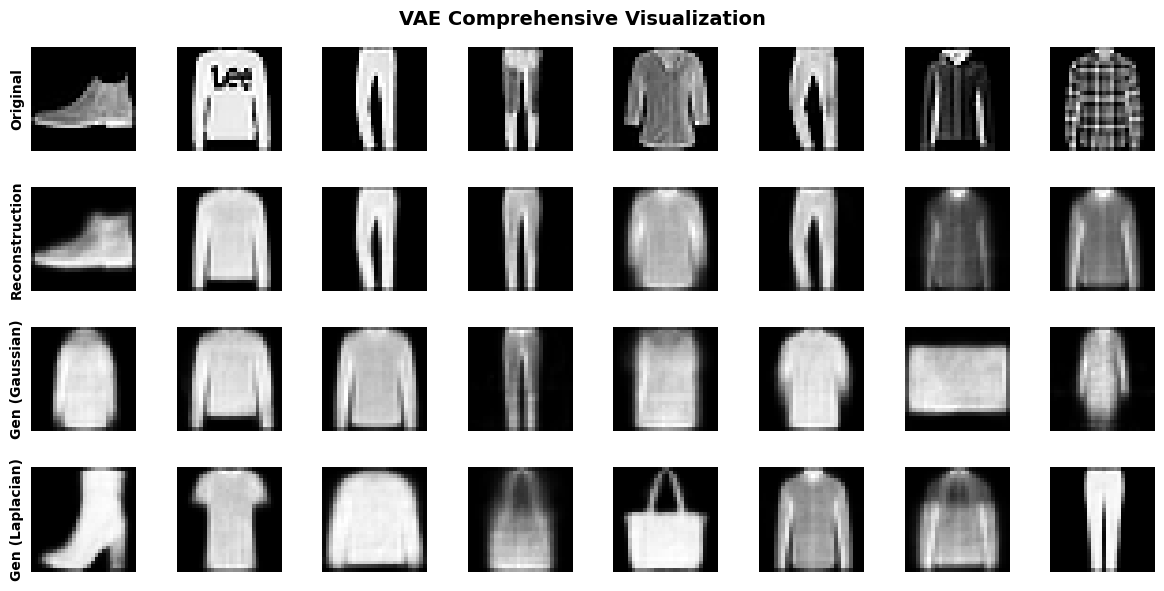


OBSERVATIONS AND FINDINGS


In [9]:
# d) document samples and descrbe observations
def comprehensive_visualization(model, test_loader, n_samples=8, latent_dim=20):
    model.eval()

    # get test samples for reconstruction
    data, _ = next(iter(test_loader))
    data = data[:n_samples].to(device)

    with torch.no_grad():
        # reconstructions
        reconstruction, mu, logvar = model(data)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        # gaussian generations
        z_gaussian = torch.randn(n_samples, latent_dim).to(device)
        gen_gaussian = model.decode(z_gaussian).view(-1, 1, 28, 28)

        # laplacian generations
        z_laplacian = torch.from_numpy(
            np.random.laplace(0, 1, (n_samples, latent_dim))
        ).float().to(device)
        gen_laplacian = model.decode(z_laplacian).view(-1, 1, 28, 28)

    # create plot
    fig, axes = plt.subplots(4, n_samples, figsize=(n_samples*1.5, 6))

    for i in range(n_samples):
        # Row 1: Original images
        axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].text(-0.2, 0.5, 'Original',
                           transform=axes[0, i].transAxes,
                           fontsize=10, fontweight='bold',
                           rotation=90, va='center')

        # Row 2: reconstructions
        axes[1, i].imshow(reconstruction[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].text(-0.2, 0.5, 'Reconstruction',
                           transform=axes[1, i].transAxes,
                           fontsize=10, fontweight='bold',
                           rotation=90, va='center')

        # Row 3: gaussian generations
        axes[2, i].imshow(gen_gaussian[i].cpu().squeeze(), cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].text(-0.2, 0.5, 'Gen (Gaussian)',
                           transform=axes[2, i].transAxes,
                           fontsize=10, fontweight='bold',
                           rotation=90, va='center')

        # Row 4: laplacian generations
        axes[3, i].imshow(gen_laplacian[i].cpu().squeeze(), cmap='gray')
        axes[3, i].axis('off')
        if i == 0:
            axes[3, i].text(-0.2, 0.5, 'Gen (Laplacian)',
                           transform=axes[3, i].transAxes,
                           fontsize=10, fontweight='bold',
                           rotation=90, va='center')

    plt.suptitle('VAE Comprehensive Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('vae_comprehensive.png', dpi=300, bbox_inches='tight')
    print("Saved: vae_comprehensive.png")
    plt.show()


# create visualization
comprehensive_visualization(model, test_loader, n_samples=8, latent_dim=latent_dim)

print("\n" + "="*70)
print("OBSERVATIONS AND FINDINGS")
print("="*70)





# **Part 3: Posterior Collapse Investigation**


EXAMINING FOR POSTERIOR COLLAPSE
Saved: posterior_collapse_check.png


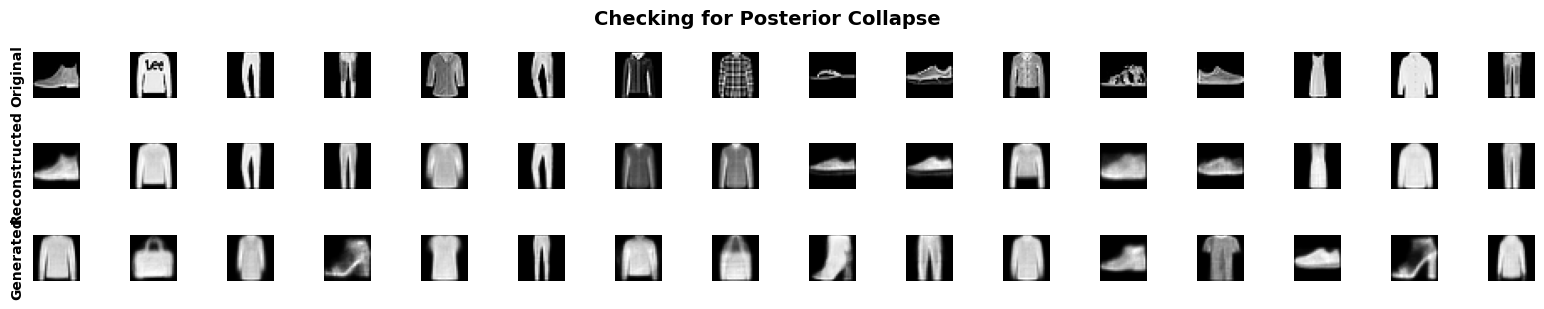

In [11]:
# a) examine reconstrcutins and generations for posterior collapse

def examine_posterior_collapse(model, test_loader, latent_dim=20):
    model.eval()

    print("\n" + "="*70)
    print("EXAMINING FOR POSTERIOR COLLAPSE")
    print("="*70)

    # get test samples
    data, _ = next(iter(test_loader))
    data = data[:16].to(device)

    with torch.no_grad():
        # get reconstructions and latent codes
        reconstruction, mu, logvar = model(data)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        # generate from prior
        z_prior = torch.randn(16, latent_dim).to(device)
        generations = model.decode(z_prior).view(-1, 1, 28, 28)

    # visualize
    fig, axes = plt.subplots(3, 16, figsize=(16, 3))

    for i in range(16):
        # original
        axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')

        # reconstruction
        axes[1, i].imshow(reconstruction[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

        # generation
        axes[2, i].imshow(generations[i].cpu().squeeze(), cmap='gray')
        axes[2, i].axis('off')

    # add row labels
    axes[0, 0].text(-0.5, 0.5, 'Original', transform=axes[0, 0].transAxes,
                    fontsize=10, fontweight='bold', rotation=90, va='center')
    axes[1, 0].text(-0.5, 0.5, 'Reconstructed', transform=axes[1, 0].transAxes,
                    fontsize=10, fontweight='bold', rotation=90, va='center')
    axes[2, 0].text(-0.5, 0.5, 'Generated', transform=axes[2, 0].transAxes,
                    fontsize=10, fontweight='bold', rotation=90, va='center')

    plt.suptitle('Checking for Posterior Collapse', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('posterior_collapse_check.png', dpi=300, bbox_inches='tight')
    print("Saved: posterior_collapse_check.png")
    plt.show()


# examine for posterior collapse
examine_posterior_collapse(model, test_loader, latent_dim=latent_dim)


ANALYZING ELBO COMPONENTS

Final Validation Losses (per sample):
  Reconstruction Loss: 16.1743
  KL Divergence:       7.2803
  Total Loss (ELBO):   23.4546

  Recon/KLD Ratio:     2.22

----------------------------------------------------------------------
POSTERIOR COLLAPSE INDICATORS:
----------------------------------------------------------------------
✓ KL Divergence is reasonable (> 1.0)
  → Encoder is learning
----------------------------------------------------------------------

Saved: elbo_analysis.png


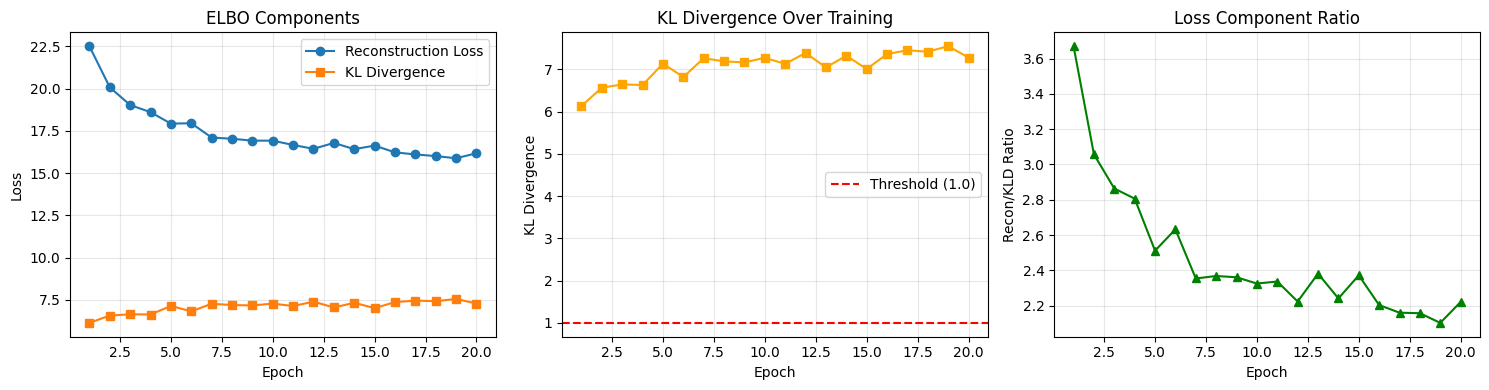

In [12]:
# b) analyze the ELBO componenents
def analyze_elbo_components(history):
    print("\n" + "="*70)
    print("ANALYZING ELBO COMPONENTS")
    print("="*70)

    final_recon = history['val_recon'][-1]
    final_kld = history['val_kld'][-1]
    final_total = history['val_loss'][-1]

    print(f"\nFinal Validation Losses (per sample):")
    print(f"  Reconstruction Loss: {final_recon:.4f}")
    print(f"  KL Divergence:       {final_kld:.4f}")
    print(f"  Total Loss (ELBO):   {final_total:.4f}")

    # compute ratio
    if final_kld > 0:
        ratio = final_recon / final_kld
        print(f"\n  Recon/KLD Ratio:     {ratio:.2f}")

    # check for collapse
    print("\n" + "-"*70)
    print("POSTERIOR COLLAPSE INDICATORS:")
    print("-"*70)

    if final_kld < 0.1:
        print("✗ KL Divergence is VERY LOW (< 0.1)")
        print("  → Strong indication of posterior collapse")
        print("  → Encoder is ignoring input, outputting N(0, I)")
    elif final_kld < 1.0:
        print("⚠ KL Divergence is LOW (< 1.0)")
        print("  → Possible posterior collapse")
        print("  → Encoder may not be learning meaningful representations")
    else:
        print("✓ KL Divergence is reasonable (> 1.0)")
        print("  → Encoder is learning")

    if final_kld < 0.1 and final_recon > 10.0:
        print("\n✗ POSTERIOR COLLAPSE DETECTED!")
        print("  → KL divergence near zero")
        print("  → Reconstruction loss still high")
        print("  → Decoder ignoring latent codes, generating average image")

    print("-"*70)

    # plot ELBO components over training
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    epochs = range(1, len(history['val_loss']) + 1)

    # plot 1: Both components
    ax1 = axes[0]
    ax1.plot(epochs, history['val_recon'], label='Reconstruction Loss', marker='o')
    ax1.plot(epochs, history['val_kld'], label='KL Divergence', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('ELBO Components')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # plot 2: KL divergence alone
    axes[1].plot(epochs, history['val_kld'], color='orange', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('KL Divergence')
    axes[1].set_title('KL Divergence Over Training')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=1.0, color='r', linestyle='--', label='Threshold (1.0)')
    axes[1].legend()

    # plot 3: Ratio
    ratio_over_time = [r/k if k > 0 else 0 for r, k in
                       zip(history['val_recon'], history['val_kld'])]
    axes[2].plot(epochs, ratio_over_time, color='green', marker='^')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Recon/KLD Ratio')
    axes[2].set_title('Loss Component Ratio')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('elbo_analysis.png', dpi=300, bbox_inches='tight')
    print("\nSaved: elbo_analysis.png")
    plt.show()


# analyze ELBO components
analyze_elbo_components(history)


CHECKING POSTERIOR STATISTICS

Analyzed 100 samples
Latent dimension: 20

Posterior Statistics:
  Mean μ (should be ≈ 0 if collapsed):    0.0027
  Std of μ (should be low if collapsed):  0.2513
  Mean variance (should be ≈ 1 if collapsed): 0.7780

----------------------------------------------------------------------
COLLAPSE INDICATORS:
----------------------------------------------------------------------
✗ COLLAPSED: μ is very close to 0 with low variance
  → Encoder outputs are ignoring input
  → All inputs map to similar latent codes

✓ Variance differs from prior
----------------------------------------------------------------------

Saved: posterior_statistics.png


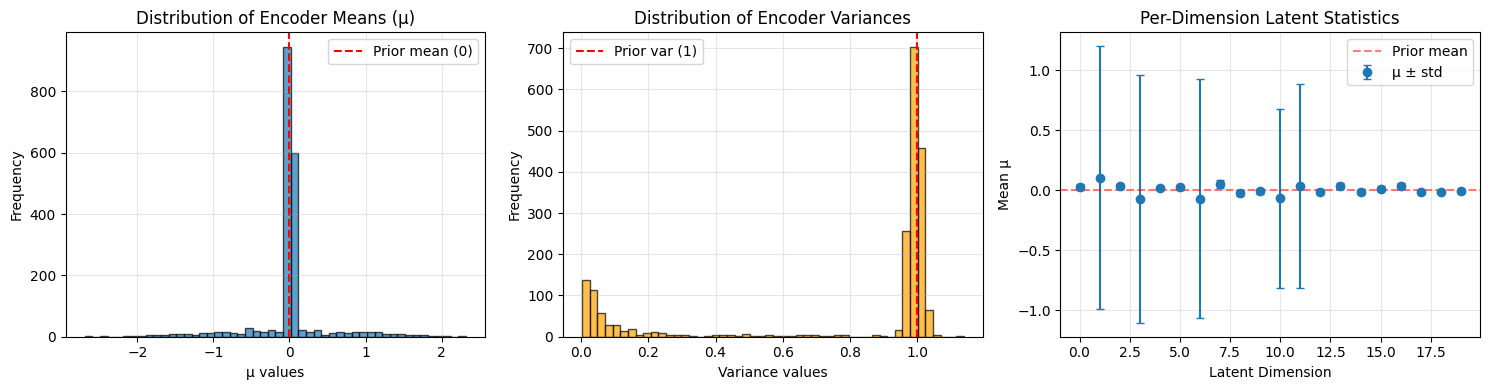

In [13]:
# c) confirm if posterior q(z|x) collapses
def check_posterior_statistics(model, test_loader, n_samples=100):
    model.eval()

    print("\n" + "="*70)
    print("CHECKING POSTERIOR STATISTICS")
    print("="*70)

    all_mu = []
    all_logvar = []

    # collect encoder outputs
    with torch.no_grad():
        count = 0
        for data, _ in test_loader:
            if count >= n_samples:
                break

            data = data.to(device)
            data_flat = data.view(-1, 28*28)

            mu, logvar = model.encode(data_flat)
            all_mu.append(mu.cpu().numpy())
            all_logvar.append(logvar.cpu().numpy())

            count += data.size(0)

    all_mu = np.vstack(all_mu)[:n_samples]
    all_logvar = np.vstack(all_logvar)[:n_samples]
    all_var = np.exp(all_logvar)

    # compute statistics
    mean_mu = np.mean(all_mu, axis=0)
    std_mu = np.std(all_mu, axis=0)
    mean_var = np.mean(all_var, axis=0)

    print(f"\nAnalyzed {n_samples} samples")
    print(f"Latent dimension: {all_mu.shape[1]}")

    print("\nPosterior Statistics:")
    print(f"  Mean μ (should be ≈ 0 if collapsed):    {np.mean(mean_mu):.4f}")
    print(f"  Std of μ (should be low if collapsed):  {np.mean(std_mu):.4f}")
    print(f"  Mean variance (should be ≈ 1 if collapsed): {np.mean(mean_var):.4f}")

    # check for collapse
    print("\n" + "-"*70)
    print("COLLAPSE INDICATORS:")
    print("-"*70)

    if np.abs(np.mean(mean_mu)) < 0.1 and np.mean(std_mu) < 0.5:
        print("✗ COLLAPSED: μ is very close to 0 with low variance")
        print("  → Encoder outputs are ignoring input")
        print("  → All inputs map to similar latent codes")
    elif np.mean(std_mu) < 1.0:
        print("⚠ PARTIAL COLLAPSE: Low variance in μ")
        print("  → Encoder is not using full latent space")
    else:
        print("✓ NO COLLAPSE: μ shows good variance")
        print("  → Encoder is learning meaningful representations")

    if np.abs(np.mean(mean_var) - 1.0) < 0.2:
        print("\n✗ COLLAPSED: Variance is very close to 1 (prior variance)")
        print("  → Encoder outputs match prior distribution")
    else:
        print("\n✓ Variance differs from prior")

    print("-"*70)

    # visualize latent space statistics
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # plot 1: Distribution of mu values
    axes[0].hist(all_mu.flatten(), bins=50, alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0, color='r', linestyle='--', label='Prior mean (0)')
    axes[0].set_xlabel('μ values')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Encoder Means (μ)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # plot 2: Distribution of variance values
    axes[1].hist(all_var.flatten(), bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1].axvline(x=1, color='r', linestyle='--', label='Prior var (1)')
    axes[1].set_xlabel('Variance values')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Encoder Variances')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # plot 3: Per-dimension statistics
    latent_dims = range(all_mu.shape[1])
    axes[2].errorbar(latent_dims, mean_mu, yerr=std_mu,
                     fmt='o', capsize=3, label='μ ± std')
    axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Prior mean')
    axes[2].set_xlabel('Latent Dimension')
    axes[2].set_ylabel('Mean μ')
    axes[2].set_title('Per-Dimension Latent Statistics')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('posterior_statistics.png', dpi=300, bbox_inches='tight')
    print("\nSaved: posterior_statistics.png")
    plt.show()


# Check posterior statistics
check_posterior_statistics(model, test_loader, n_samples=100)

# **Part 4: Mitigating Posterior Collapse**

In [15]:
# a)design and implement a strategy to prevent posterior collapse
"""
KL ANNEALING  is used to mitigate this issue (also called β-annealing):

Main idea: Gradually introduce the KL term during training
- Start with β = 0 (no KL penalty) → encoder learns to encode information
- Slowly increase β to 1 → gradually enforce prior matching
- This gives encoder time to learn meaningful representations before KLD kicks in

Mathematical formulation:
  Loss = Reconstruction_Loss + β(t) * KL_Divergence

where β(t) increases from 0 to 1 over training epochs.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def get_beta_schedule(epoch, num_epochs, anneal_type='linear'):
    if anneal_type == 'linear':
        # linear increase from 0 to 1
        warmup_epochs = num_epochs // 2  # Warmup for half of training
        if epoch < warmup_epochs:
            beta = epoch / warmup_epochs
        else:
            beta = 1.0

    elif anneal_type == 'cosine':
        # cosine annealing
        warmup_epochs = num_epochs // 2
        if epoch < warmup_epochs:
            beta = 0.5 * (1 - np.cos(np.pi * epoch / warmup_epochs))
        else:
            beta = 1.0

    elif anneal_type == 'cyclical':
        # cyclical annealing (multiple cycles)
        cycle_length = num_epochs // 4
        progress = (epoch % cycle_length) / cycle_length
        beta = progress

    else:
        beta = 1.0  # No annealing

    return beta


def vae_loss_with_beta(reconstruction, x, mu, logvar, beta=1.0):
    # flatten inputs
    x = x.view(-1, 28*28)

    # reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(reconstruction, x, reduction='sum')

    # kL divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # total loss with beta weighting
    total_loss = recon_loss + beta * kld_loss

    return total_loss, recon_loss, kld_loss


def train_vae_with_annealing(model, train_loader, optimizer, epoch, num_epochs, anneal_type='linear'):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kld_loss = 0

    # get beta for this epoch
    beta = get_beta_schedule(epoch, num_epochs, anneal_type)

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()

        # forward pass
        reconstruction, mu, logvar = model(data)

        # compute loss with beta weighting
        loss, recon_loss, kld_loss = vae_loss_with_beta(reconstruction, data, mu, logvar, beta)

        # backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kld_loss += kld_loss.item()

    # average losses
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = train_recon_loss / len(train_loader.dataset)
    avg_kld = train_kld_loss / len(train_loader.dataset)

    return avg_loss, avg_recon, avg_kld, beta


def validate_vae_with_beta(model, test_loader, beta=1.0):
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    val_kld_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)

            # forward pass
            reconstruction, mu, logvar = model(data)

            # compute loss
            loss, recon_loss, kld_loss = vae_loss_with_beta(reconstruction, data, mu, logvar, beta)

            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_kld_loss += kld_loss.item()

    # average losses
    avg_loss = val_loss / len(test_loader.dataset)
    avg_recon = val_recon_loss / len(test_loader.dataset)
    avg_kld = val_kld_loss / len(test_loader.dataset)

    return avg_loss, avg_recon, avg_kld


# initialize new model for annealing experiment
print("\n" + "="*70)
print("TRAINING VAE WITH KL ANNEALING")
print("="*70)

model_annealed = VAE(latent_dim=20).to(device)
optimizer_annealed = optim.Adam(model_annealed.parameters(), lr=1e-3)

num_epochs = 30
anneal_type = 'linear'  # Can try 'cosine' or 'cyclical'

print(f"\nTraining Configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Annealing type: {anneal_type}")
print(f"  Beta schedule: 0 → 1 over first {num_epochs//2} epochs")

# track history
history_annealed = {
    'train_loss': [], 'train_recon': [], 'train_kld': [],
    'val_loss': [], 'val_recon': [], 'val_kld': [],
    'beta': []
}




TRAINING VAE WITH KL ANNEALING

Training Configuration:
  Epochs: 30
  Annealing type: linear
  Beta schedule: 0 → 1 over first 15 epochs


Epoch 1/30 | Beta: 0.000
  Train - Loss: 26.3450 | Recon: 26.3450 | KLD: 127.4306
  Val   - Loss: 213.8377 | Recon: 16.1251 | KLD: 197.7126
Epoch 5/30 | Beta: 0.267
  Train - Loss: 17.4189 | Recon: 12.9273 | KLD: 16.8434
  Val   - Loss: 29.4703 | Recon: 12.6948 | KLD: 16.7755
Epoch 10/30 | Beta: 0.600
  Train - Loss: 20.4611 | Recon: 13.5610 | KLD: 11.5001
  Val   - Loss: 24.9448 | Recon: 14.0166 | KLD: 10.9282
Epoch 15/30 | Beta: 0.933
  Train - Loss: 23.3626 | Recon: 14.8274 | KLD: 9.1449
  Val   - Loss: 23.9968 | Recon: 14.6265 | KLD: 9.3703
Epoch 20/30 | Beta: 1.000
  Train - Loss: 23.5970 | Recon: 14.9840 | KLD: 8.6130
  Val   - Loss: 23.7164 | Recon: 15.0676 | KLD: 8.6488
Epoch 25/30 | Beta: 1.000
  Train - Loss: 23.3550 | Recon: 14.8288 | KLD: 8.5262
  Val   - Loss: 23.4975 | Recon: 15.0639 | KLD: 8.4336
Epoch 30/30 | Beta: 1.000
  Train - Loss: 23.1580 | Recon: 14.6589 | KLD: 8.4991
  Val   - Loss: 23.2552 | Recon: 15.0113 | KLD: 8.2439

Model saved as 'vae_annealed.pth'
Saved:

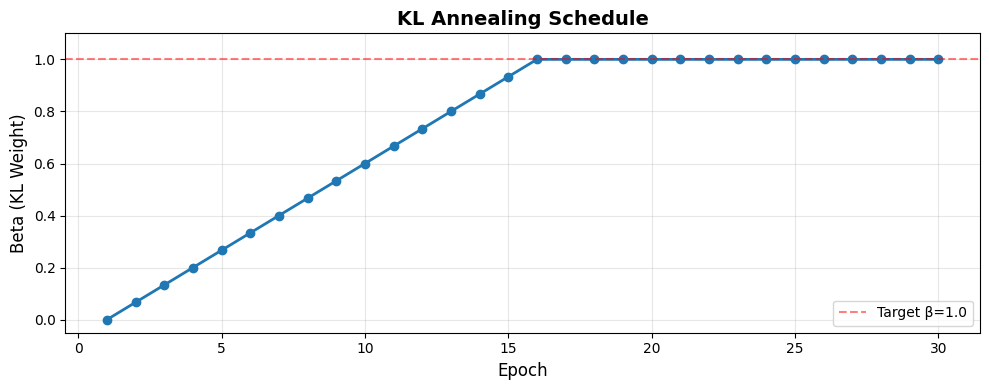

In [16]:
# b) graudal kl term
# training loop with KL annealing
for epoch in range(num_epochs):
    # train with annealing
    train_loss, train_recon, train_kld, beta = train_vae_with_annealing(
        model_annealed, train_loader, optimizer_annealed, epoch, num_epochs, anneal_type
    )

    # validate (always with beta=1.0 for fair comparison)
    val_loss, val_recon, val_kld = validate_vae_with_beta(model_annealed, test_loader, beta=1.0)

    # record history
    history_annealed['train_loss'].append(train_loss)
    history_annealed['train_recon'].append(train_recon)
    history_annealed['train_kld'].append(train_kld)
    history_annealed['val_loss'].append(val_loss)
    history_annealed['val_recon'].append(val_recon)
    history_annealed['val_kld'].append(val_kld)
    history_annealed['beta'].append(beta)

    # print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Beta: {beta:.3f}")
        print(f"  Train - Loss: {train_loss:.4f} | Recon: {train_recon:.4f} | KLD: {train_kld:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f} | Recon: {val_recon:.4f} | KLD: {val_kld:.4f}")

# save model
torch.save(model_annealed.state_dict(), 'vae_annealed.pth')
print("\nModel saved as 'vae_annealed.pth'")

# plot beta schedule
plt.figure(figsize=(10, 4))
epochs_range = range(1, num_epochs + 1)
plt.plot(epochs_range, history_annealed['beta'], marker='o', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Beta (KL Weight)', fontsize=12)
plt.title('KL Annealing Schedule', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim([-0.05, 1.1])
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Target β=1.0')
plt.legend()
plt.tight_layout()
plt.savefig('beta_schedule.png', dpi=300)
print("Saved: beta_schedule.png")
plt.show()


COMPARING ORIGINAL VS ANNEALED VAE

Final Validation Metrics:
----------------------------------------------------------------------
Metric                    Original VAE         Annealed VAE        
----------------------------------------------------------------------
Reconstruction Loss       16.1743              15.0113             
KL Divergence             7.2803               8.2439              
Total Loss (ELBO)         23.4546              23.2552             
----------------------------------------------------------------------

Posterior Collapse Assessment:
  Original VAE: ✓ No collapse (KLD ≥ 0.5)
  Annealed VAE: ✓ No collapse (KLD ≥ 0.5)

Improvement with Annealing:
  KLD change: +0.9636 (higher is better - more informative latents)
  Reconstruction improvement: +1.1630 (lower recon loss is better)

Saved: vae_comparison.png


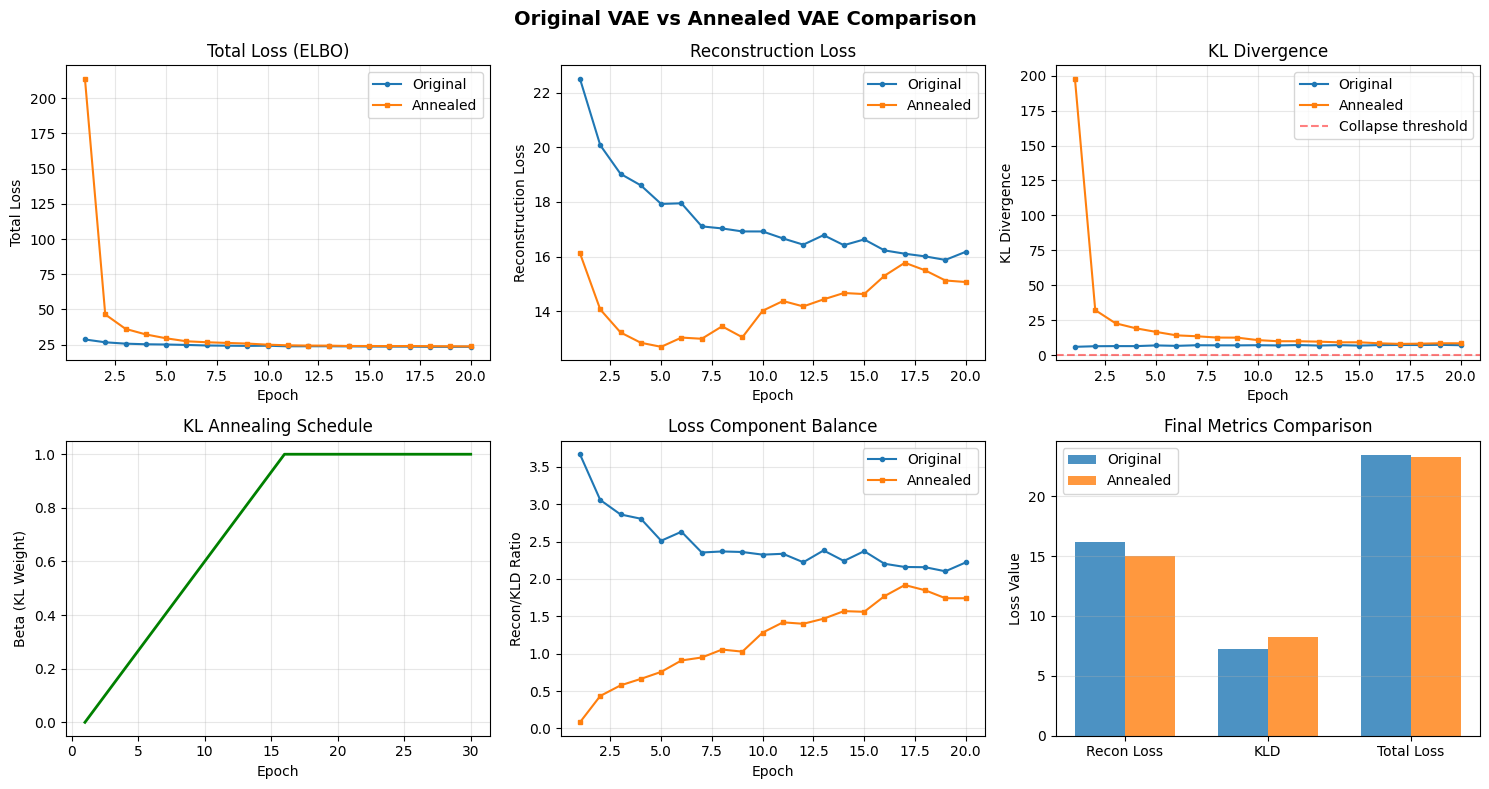

Saved: vae_visual_comparison.png


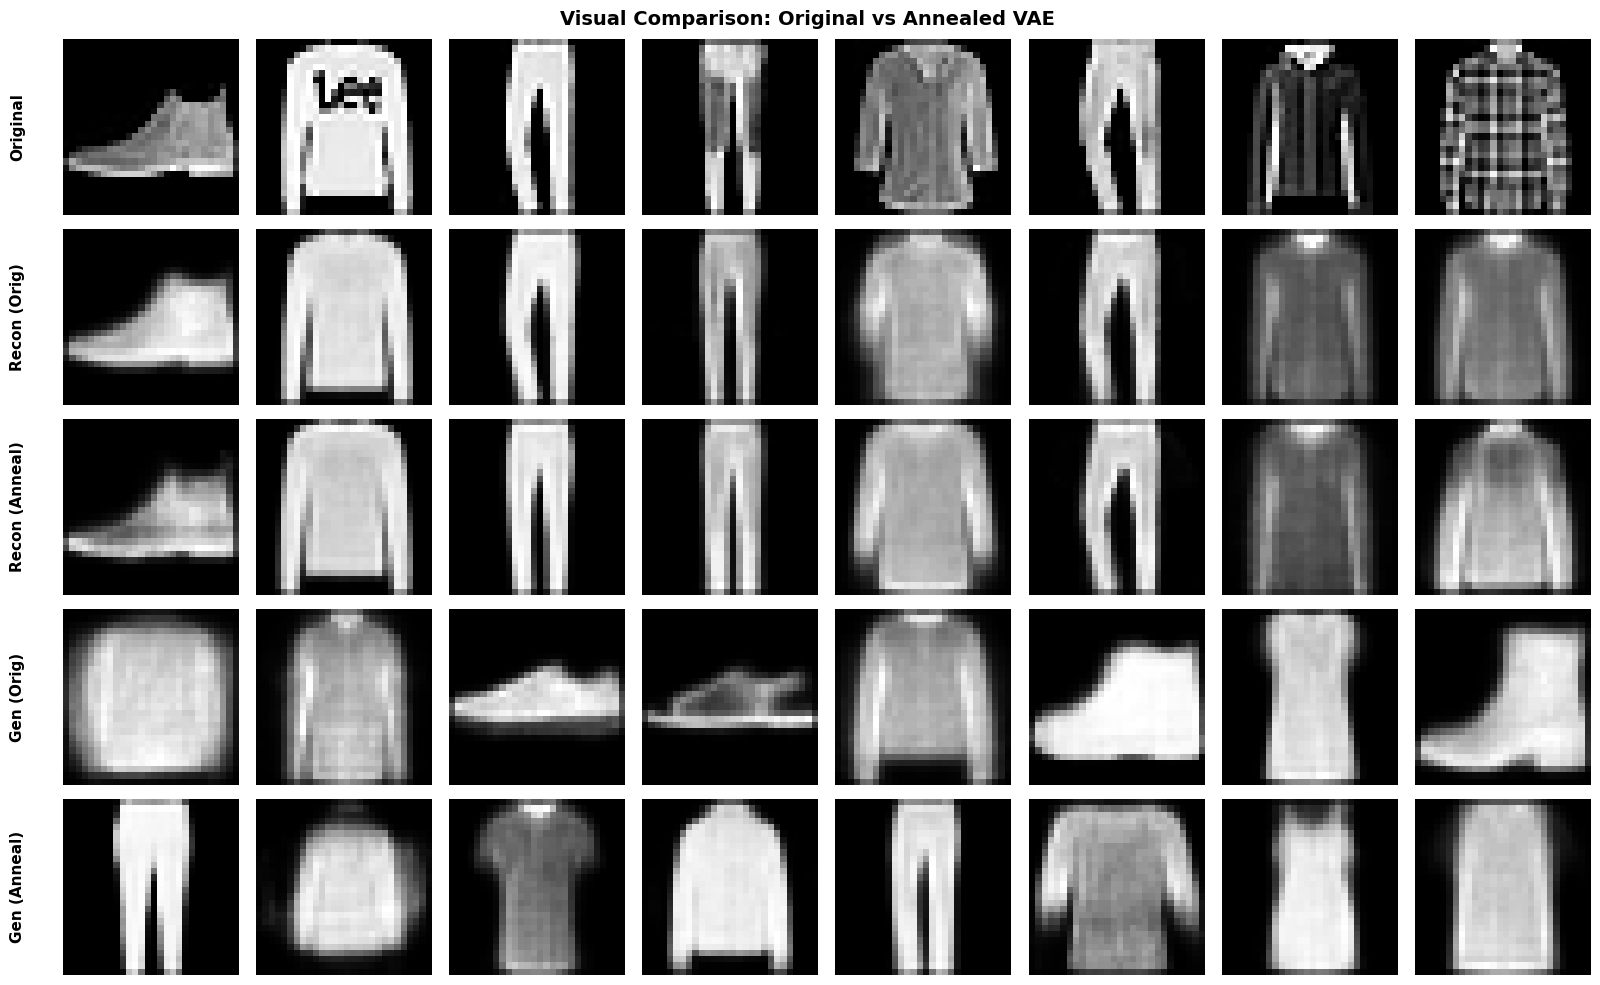

In [18]:
# c) compare results and explaination
def compare_original_vs_annealed(history_original, history_annealed):
    print("\n" + "="*70)
    print("COMPARING ORIGINAL VS ANNEALED VAE")
    print("="*70)

    # Final metrics
    print("\nFinal Validation Metrics:")
    print("-"*70)
    print(f"{'Metric':<25} {'Original VAE':<20} {'Annealed VAE':<20}")
    print("-"*70)
    print(f"{'Reconstruction Loss':<25} {history_original['val_recon'][-1]:<20.4f} {history_annealed['val_recon'][-1]:<20.4f}")
    print(f"{'KL Divergence':<25} {history_original['val_kld'][-1]:<20.4f} {history_annealed['val_kld'][-1]:<20.4f}")
    print(f"{'Total Loss (ELBO)':<25} {history_original['val_loss'][-1]:<20.4f} {history_annealed['val_loss'][-1]:<20.4f}")
    print("-"*70)

    # check for collapse
    original_collapsed = history_original['val_kld'][-1] < 0.5
    annealed_collapsed = history_annealed['val_kld'][-1] < 0.5

    print("\nPosterior Collapse Assessment:")
    if original_collapsed:
        print("  Original VAE: ✗ COLLAPSED (KLD < 0.5)")
    else:
        print("  Original VAE: ✓ No collapse (KLD ≥ 0.5)")

    if annealed_collapsed:
        print("  Annealed VAE: ✗ COLLAPSED (KLD < 0.5)")
    else:
        print("  Annealed VAE: ✓ No collapse (KLD ≥ 0.5)")

    # improvement
    kld_improvement = history_annealed['val_kld'][-1] - history_original['val_kld'][-1]
    recon_improvement = history_original['val_recon'][-1] - history_annealed['val_recon'][-1]

    print("\nImprovement with Annealing:")
    print(f"  KLD change: {kld_improvement:+.4f} (higher is better - more informative latents)")
    print(f"  Reconstruction improvement: {recon_improvement:+.4f} (lower recon loss is better)")

    # plot comparison
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # align epochs (original may have different length)
    min_epochs = min(len(history_original['val_loss']), len(history_annealed['val_loss']))
    epochs = range(1, min_epochs + 1)

    # Row 1: Loss components
    # total loss
    axes[0, 0].plot(epochs, history_original['val_loss'][:min_epochs],
                    label='Original', marker='o', markersize=3)
    axes[0, 0].plot(epochs, history_annealed['val_loss'][:min_epochs],
                    label='Annealed', marker='s', markersize=3)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Total Loss')
    axes[0, 0].set_title('Total Loss (ELBO)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # reconstruction loss
    axes[0, 1].plot(epochs, history_original['val_recon'][:min_epochs],
                    label='Original', marker='o', markersize=3)
    axes[0, 1].plot(epochs, history_annealed['val_recon'][:min_epochs],
                    label='Annealed', marker='s', markersize=3)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Reconstruction Loss')
    axes[0, 1].set_title('Reconstruction Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # KL divergence
    axes[0, 2].plot(epochs, history_original['val_kld'][:min_epochs],
                    label='Original', marker='o', markersize=3)
    axes[0, 2].plot(epochs, history_annealed['val_kld'][:min_epochs],
                    label='Annealed', marker='s', markersize=3)
    axes[0, 2].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Collapse threshold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('KL Divergence')
    axes[0, 2].set_title('KL Divergence')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # row 2: Visualizations
    # beta schedule (for annealed only)
    axes[1, 0].plot(range(1, len(history_annealed['beta']) + 1),
                    history_annealed['beta'], linewidth=2, color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Beta (KL Weight)')
    axes[1, 0].set_title('KL Annealing Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # recon/KLD ratio
    ratio_original = [r/k if k > 0.01 else 0 for r, k in
                     zip(history_original['val_recon'][:min_epochs],
                         history_original['val_kld'][:min_epochs])]
    ratio_annealed = [r/k if k > 0.01 else 0 for r, k in
                     zip(history_annealed['val_recon'][:min_epochs],
                         history_annealed['val_kld'][:min_epochs])]

    axes[1, 1].plot(epochs, ratio_original, label='Original', marker='o', markersize=3)
    axes[1, 1].plot(epochs, ratio_annealed, label='Annealed', marker='s', markersize=3)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recon/KLD Ratio')
    axes[1, 1].set_title('Loss Component Balance')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # final comparison bar chart
    metrics = ['Recon Loss', 'KLD', 'Total Loss']
    original_vals = [history_original['val_recon'][-1],
                    history_original['val_kld'][-1],
                    history_original['val_loss'][-1]]
    annealed_vals = [history_annealed['val_recon'][-1],
                    history_annealed['val_kld'][-1],
                    history_annealed['val_loss'][-1]]

    x = np.arange(len(metrics))
    width = 0.35

    axes[1, 2].bar(x - width/2, original_vals, width, label='Original', alpha=0.8)
    axes[1, 2].bar(x + width/2, annealed_vals, width, label='Annealed', alpha=0.8)
    axes[1, 2].set_ylabel('Loss Value')
    axes[1, 2].set_title('Final Metrics Comparison')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(metrics)
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3, axis='y')

    plt.suptitle('Original VAE vs Annealed VAE Comparison',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('vae_comparison.png', dpi=300, bbox_inches='tight')
    print("\nSaved: vae_comparison.png")
    plt.show()


# compare models
compare_original_vs_annealed(history, history_annealed)


# visualize reconstructions and generations from annealed model
def compare_generations(model_original, model_annealed, test_loader, latent_dim=20):
    model_original.eval()
    model_annealed.eval()

    # get test samples
    data, _ = next(iter(test_loader))
    data = data[:8].to(device)

    with torch.no_grad():
        # reconstructions
        recon_original, _, _ = model_original(data)
        recon_original = recon_original.view(-1, 1, 28, 28)

        recon_annealed, _, _ = model_annealed(data)
        recon_annealed = recon_annealed.view(-1, 1, 28, 28)

        # generations
        z = torch.randn(8, latent_dim).to(device)

        gen_original = model_original.decode(z).view(-1, 1, 28, 28)
        gen_annealed = model_annealed.decode(z).view(-1, 1, 28, 28)

    # plot
    fig, axes = plt.subplots(5, 8, figsize=(16, 10))

    for i in range(8):
        # original images
        axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')

        # original VAE reconstructions
        axes[1, i].imshow(recon_original[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

        # Annealed VAE reconstructions
        axes[2, i].imshow(recon_annealed[i].cpu().squeeze(), cmap='gray')
        axes[2, i].axis('off')

        # original VAE generations
        axes[3, i].imshow(gen_original[i].cpu().squeeze(), cmap='gray')
        axes[3, i].axis('off')

        # annealed VAE generations
        axes[4, i].imshow(gen_annealed[i].cpu().squeeze(), cmap='gray')
        axes[4, i].axis('off')

    # row labels
    axes[0, 0].text(-0.3, 0.5, 'Original', transform=axes[0, 0].transAxes,
                    fontsize=11, fontweight='bold', rotation=90, va='center')
    axes[1, 0].text(-0.3, 0.5, 'Recon (Orig)', transform=axes[1, 0].transAxes,
                    fontsize=11, fontweight='bold', rotation=90, va='center')
    axes[2, 0].text(-0.3, 0.5, 'Recon (Anneal)', transform=axes[2, 0].transAxes,
                    fontsize=11, fontweight='bold', rotation=90, va='center')
    axes[3, 0].text(-0.3, 0.5, 'Gen (Orig)', transform=axes[3, 0].transAxes,
                    fontsize=11, fontweight='bold', rotation=90, va='center')
    axes[4, 0].text(-0.3, 0.5, 'Gen (Anneal)', transform=axes[4, 0].transAxes,
                    fontsize=11, fontweight='bold', rotation=90, va='center')

    plt.suptitle('Visual Comparison: Original vs Annealed VAE',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('vae_visual_comparison.png', dpi=300, bbox_inches='tight')
    print("Saved: vae_visual_comparison.png")
    plt.show()


# compare generations
compare_generations(model, model_annealed, test_loader, latent_dim=latent_dim)

